<a href="https://colab.research.google.com/github/priscillaoclark/15.773-hands-on-deep-learning/blob/main/HODL_SP25_Lec_06_Section_A_Transformers_Slot_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# HODL-SP25-Lec-6-Sec-A Using the Transformer Encoder to solve the Slot-Classification Problem



In [ ]:
import os
os.environ['KERAS_BACKEND'] = 'tensorflow'

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import keras

keras.utils.set_random_seed(42)

## Introduction



In the previous module we studied the use of NLP to classify text. We saw that bag of words and bigrams were very useful for this task. In this module we will focus on a different task for which we'll need to develop a different neural network architecture.


For this module we will use the ATIS dataset which includes queries from people trying to find travel information and book flight tickets between two destinations. The task will be to read this raw query and identify the key "entities" (or slots) in that query (which airports or cities, what days and times etc).

## Data Preprocessing



Let's begin extracting the data from the ATIS dataset and turning into a form that we can use in our Deep Learning models.

The ATIS dataset is a standard benchmark dataset widely used to build models for intent classification and slot filling tasks (we will explain all this shortly). You can find a very detailed explanation [here](https://catalog.ldc.upenn.edu/docs/LDC93S4B/corpus.html).

We will begin by loading the file and then partitioning into a test and a training set.

In [ ]:
train_url = "https://www.dropbox.com/scl/fi/m2yj95tccxmzin3mnna47/atis_train_data.csv?rlkey=p61rpu2mwxjcb1ypfh89qzull&st=omw3dkpu&dl=1"
test_url = "https://www.dropbox.com/scl/fi/d1zwrv2jslo7j93p68l75/atis_test_data.csv?rlkey=0kl75tt54i2ccau9m1fxevlhn&st=w7n0orza&dl=1"

In [ ]:
df_train = pd.read_csv(train_url, index_col=0)
df_test = pd.read_csv(test_url, index_col=0)

In [ ]:
df_train.head()

,query,intent,slot filling
0,i want to fly from boston at 838 am and arriv...,flight,O O O O O B-fromloc.city_name O B-depart_time...
1,what flights are available from pittsburgh to...,flight,O O O O O B-fromloc.city_name O B-toloc.city_...
2,what is the arrival time in san francisco for...,flight_time,O O O B-flight_time I-flight_time O B-fromloc...
3,cheapest airfare from tacoma to orlando,airfare,B-cost_relative O O B-fromloc.city_name O B-t...
4,round trip fares from pittsburgh to philadelp...,airfare,B-round_trip I-round_trip O O B-fromloc.city_...


In [ ]:
df_train['query'][0]

' i want to fly from boston at 838 am and arrive in denver at 1110 in the morning '

In [ ]:
df_train['slot filling'][0]

' O O O O O B-fromloc.city_name O B-depart_time.time I-depart_time.time O O O B-toloc.city_name O B-arrive_time.time O O B-arrive_time.period_of_day '

In [ ]:
df_train['query'][10]

' show me the flights from dallas to san francisco '

In [ ]:
df_train['slot filling'][10]

' O O O O O B-fromloc.city_name O B-toloc.city_name I-toloc.city_name '

Let's pull out the 'query' and 'slot' columns from the dataframe.

In [ ]:
query_data_train = df_train['query'].values
slot_data_train = df_train['slot filling'].values

query_data_test = df_test['query'].values
slot_data_test = df_test['slot filling'].values

The queries aren't super long and a max length of 30 should be good enough.

In [ ]:
max_query_length = 30

Let's STI the queries.

In [ ]:
# Textvec of query

# define text_vectorization layer
text_vectorization_query = keras.layers.TextVectorization(
    output_sequence_length=max_query_length
)

# run training corpus through layer to create vocab
text_vectorization_query.adapt(query_data_train)
query_vocab_size = text_vectorization_query.vocabulary_size()

In [ ]:
text_vectorization_query.vocabulary_size()

888

In [ ]:
text_vectorization_query.get_vocabulary()[:20]

['',
 '[UNK]',
 'to',
 'from',
 'flights',
 'the',
 'on',
 'what',
 'me',
 'flight',
 'boston',
 'show',
 'san',
 'i',
 'denver',
 'a',
 'francisco',
 'in',
 'and',
 'atlanta']

In [ ]:
# vectorize train and test queries
source_train = text_vectorization_query(query_data_train)
source_test = text_vectorization_query(query_data_test)

Next, we need to do STI for the output side of the problem i.e. the slots

Let's take another look at the slots.

In [ ]:
df_train['slot filling'].head()

,slot filling
0,O O O O O B-fromloc.city_name O B-depart_time...
1,O O O O O B-fromloc.city_name O B-toloc.city_...
2,O O O B-flight_time I-flight_time O B-fromloc...
3,B-cost_relative O O B-fromloc.city_name O B-t...
4,B-round_trip I-round_trip O O B-fromloc.city_...


Note the - and . in the entity names 👆. We don't want the standardization to strip those out. Nor do we want to lower-case the names.

In [ ]:
# Textvec of slots
text_vectorization_slots = keras.layers.TextVectorization(
    output_sequence_length=max_query_length,
    standardize=None
)
text_vectorization_slots.adapt(slot_data_train)
slot_vocab_size = text_vectorization_slots.vocabulary_size()

target_train = text_vectorization_slots(slot_data_train)
target_test = text_vectorization_slots(slot_data_test)


In [ ]:
text_vectorization_slots.get_vocabulary()

['',
 '[UNK]',
 'O',
 'B-toloc.city_name',
 'B-fromloc.city_name',
 'I-toloc.city_name',
 'B-depart_date.day_name',
 'B-airline_name',
 'I-fromloc.city_name',
 'B-depart_time.period_of_day',
 'I-airline_name',
 'B-depart_date.day_number',
 'B-depart_date.month_name',
 'B-depart_time.time',
 'B-round_trip',
 'B-cost_relative',
 'I-round_trip',
 'B-flight_mod',
 'B-depart_time.time_relative',
 'I-depart_time.time',
 'B-stoploc.city_name',
 'B-city_name',
 'B-class_type',
 'B-arrive_time.time',
 'B-arrive_time.time_relative',
 'I-class_type',
 'B-flight_stop',
 'I-arrive_time.time',
 'B-airline_code',
 'I-depart_date.day_number',
 'I-fromloc.airport_name',
 'B-fromloc.airport_name',
 'B-arrive_date.day_name',
 'B-toloc.state_code',
 'B-flight_number',
 'B-depart_date.today_relative',
 'B-depart_date.date_relative',
 'B-toloc.state_name',
 'B-fare_basis_code',
 'B-flight_time',
 'B-or',
 'B-arrive_time.period_of_day',
 'B-meal_description',
 'I-cost_relative',
 'I-airport_name',
 'B-fare_a

In [ ]:
text_vectorization_slots.vocabulary_size()

125

## Transformers - Encoder Model






We will now set up a DNN with a Transformer Encoder (as described in lecture).

In the next code cell, we have defined a `TokenAndPositionEmbedding` layer and a `TransformerEncoder` layer.

To use these layers flexibly, we have used the Keras subclassing API. If you aren't familiar with classes and objected-oriented programming, feel free to skip this code cell. The important thing is to learn how to use the `TokenAndPositionEmbedding` and `TransformerEncoder` layers as "lego blocks" and for that, you don't need to understand exactly how those blocks are constructed.

In [ ]:
# adapted from https://keras.io/examples/nlp/text_classification_with_transformer/


from keras import ops
from keras import layers
from keras import ops


class TransformerEncoder(layers.Layer):
    def __init__(self, embed_dim, dense_dim, num_heads):
        super().__init__()
        self.att = layers.MultiHeadAttention(num_heads=num_heads,
                                             key_dim=embed_dim,
                                             output_shape=embed_dim)
        self.ffn = keras.Sequential(
            [layers.Dense(dense_dim, activation="relu"),
             layers.Dense(embed_dim),]
        )
        self.layernorm1 = layers.LayerNormalization()
        self.layernorm2 = layers.LayerNormalization()

    def call(self, inputs):
        attn_output = self.att(inputs, inputs)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        return self.layernorm2(out1 + ffn_output)


class TokenAndPositionEmbedding(layers.Layer):
    def __init__(self, maxlen, vocab_size, embed_dim):
        super().__init__()
        self.token_emb = layers.Embedding(input_dim=vocab_size, output_dim=embed_dim)
        self.pos_emb = layers.Embedding(input_dim=maxlen, output_dim=embed_dim)

    def call(self, x):
        maxlen = ops.shape(x)[-1]
        positions = ops.arange(start=0, stop=maxlen, step=1)
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        return x + positions

Step 1: Make some design choices.

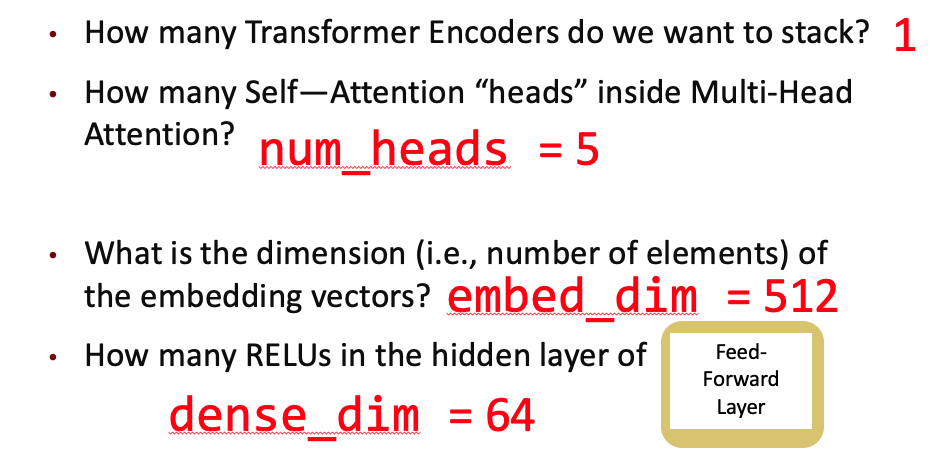

In [ ]:
# Params
embed_dim = 512
dense_dim = 64
num_heads = 5

We will first set up the token embedding and position embedding tables (see below to refresh your memory) as a Keras `TokenandPositionEmbedding`layer.

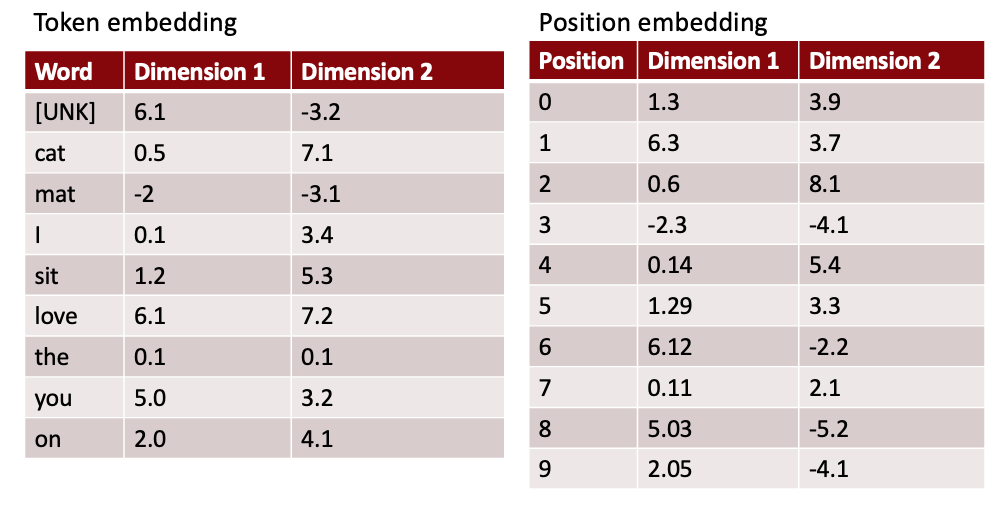

In [ ]:
embedding = TokenAndPositionEmbedding(max_query_length,
                                      query_vocab_size,
                                      embed_dim)

Next, we set up the `Transformer Encoder`.

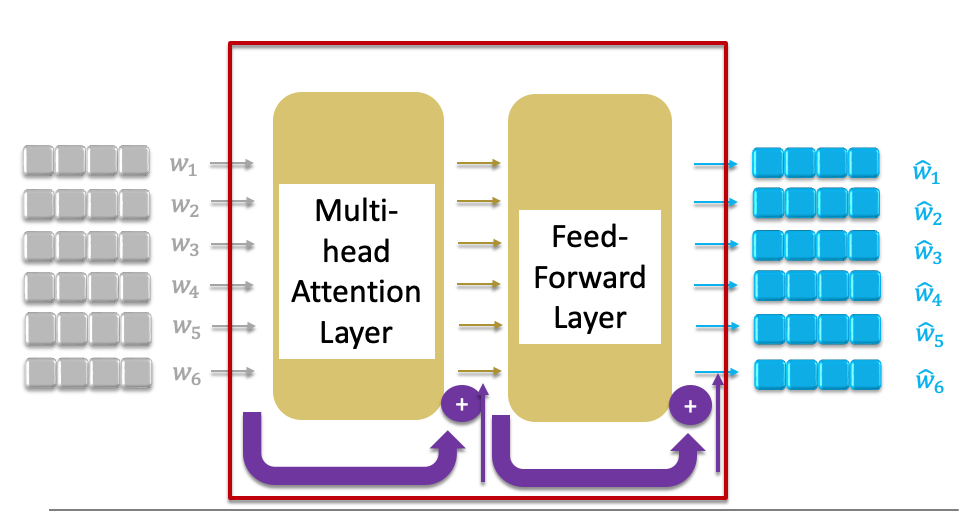

In [ ]:
te = TransformerEncoder(embed_dim,
                        dense_dim,
                        num_heads)

We are finally ready to create the full Keras model!

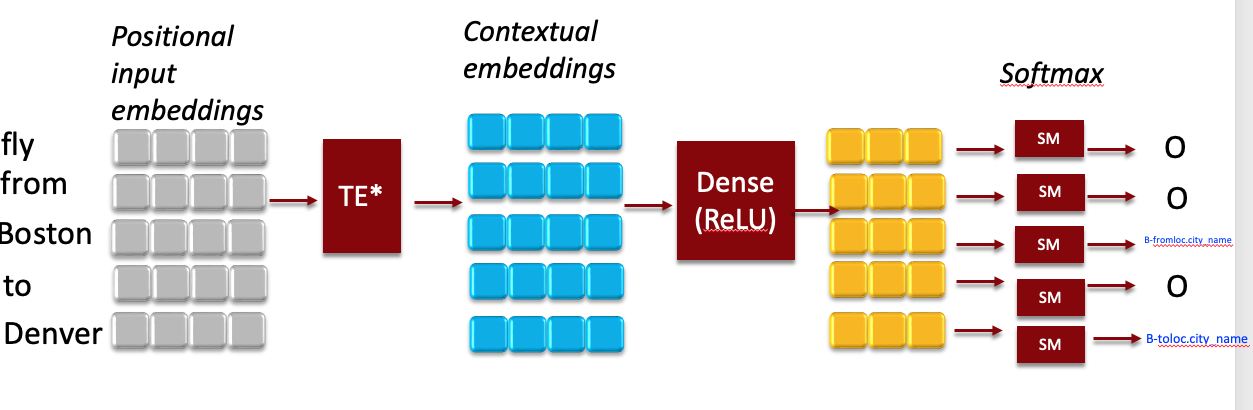

In [ ]:
# Embedding and Masking
inputs = keras.layers.Input(shape=(max_query_length,))

x = embedding(inputs) #grey vectors

encoder_out = te(x)  #encoder_out = BLUE!!! vectors

# Classifier at the end
x = keras.layers.Dense(128, activation='relu')(encoder_out)
x = keras.layers.Dropout(0.5)(x)
outputs = keras.layers.Dense(slot_vocab_size, activation="softmax")(x)

model = keras.Model(inputs, outputs)
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 30)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ token_and_position_embedding         │ (None, 30, 512)             │         470,016 │
│ (TokenAndPositionEmbedding)          │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ transformer_encoder                  │ (None, 30, 512)             │       5,319,232 │
│ (TransformerEncoder)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 30, 128)             │          65,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 30, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 30, 125)             │          16,125 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 5,871,037 (22.40 MB)

 Trainable params: 5,871,037 (22.40 MB)

 Non-trainable params: 0 (0.00 B)

**OPTIONAL**: Below, we have "hand calculated" the number of parameters in the Transformer Encoder. We encourage you to work through it and figure it out line-by-line, to ensure that you have a superbly precise understanding of the Transformer 🏅!!

In [ ]:
(num_heads * ((embed_dim + 1) * embed_dim * 3) +   # self-attention heads
(num_heads * embed_dim + 1) * embed_dim +          # concatenate-and-project
embed_dim * 2 +                                    # first layer norm
(embed_dim + 1) * dense_dim +                      # first feed-forward
(dense_dim + 1) * (embed_dim) +                    # final feed-forward
 embed_dim * 2)                                    # final layer norm

5319232

BTW, you can peek into any layer's weights easily using its `weights` attribute.

Let's say we want to check out the weights of the `TokenAndPositionalEmbedding` layer in the model above.

In [ ]:
embedding.weights

[<Variable path=token_and_position_embedding/embedding/embeddings, shape=(888, 512), dtype=float32, value=[[ 0.03581891  0.01626286 -0.01412892 ...  0.0452905  -0.02311034
    0.02508745]
  [ 0.02021731  0.01918722 -0.00385682 ...  0.02363205 -0.02280219
   -0.00295401]
  [-0.01289467  0.03753278 -0.00539821 ...  0.02464176 -0.01119621
    0.01759655]
  ...
  [ 0.02409312 -0.00869781 -0.01521801 ...  0.00323968  0.01492134
   -0.01377813]
  [ 0.04109884  0.0002197   0.01844469 ... -0.04935136 -0.02678368
   -0.01112056]
  [-0.00839518 -0.02063971  0.00734846 ...  0.01073778  0.00010662
    0.02275636]]>,
 <Variable path=token_and_position_embedding/embedding_1/embeddings, shape=(30, 512), dtype=float32, value=[[ 0.04791559 -0.00179821  0.02660979 ...  0.02429681 -0.02299124
   -0.01301686]
  [-0.0365486  -0.01160147 -0.04650236 ... -0.03935713 -0.04289023
    0.04146255]
  [-0.02161982  0.01293555 -0.02727276 ... -0.02790877 -0.04306101
    0.04120204]
  ...
  [-0.00329853 -0.01233319 

In [ ]:
model.compile(optimizer="adam",
              loss="sparse_categorical_crossentropy",
              metrics=["sparse_categorical_accuracy"])


In [ ]:
BATCH_SIZE = 64
epochs = 10

# Fit
history = model.fit(source_train, target_train,
                 batch_size=BATCH_SIZE,
                 epochs=epochs)

Epoch 1/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 15s 90ms/step - loss: 0.9894 - sparse_categorical_accuracy: 0.8222
Epoch 2/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - loss: 0.1506 - sparse_categorical_accuracy: 0.9572
Epoch 3/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - loss: 0.1069 - sparse_categorical_accuracy: 0.9666
Epoch 4/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - loss: 0.0807 - sparse_categorical_accuracy: 0.9754
Epoch 5/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - loss: 0.0608 - sparse_categorical_accuracy: 0.9816
Epoch 6/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - loss: 0.0483 - sparse_categorical_accuracy: 0.9862
Epoch 7/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - loss: 0.0386 - sparse_categorical_accuracy: 0.9886
Epoch 8/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - loss: 0.0294 - sparse_categorical_accuracy: 0.9911
Epoch 9/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - loss: 0.0259 - sparse_categorical_accuracy: 0.9921
Epoch 10/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - loss: 0.0

The accuracy on the training set is over 99%! What is it on the test set?

In [ ]:
print(f"Test set accuracy: {model.evaluate(source_test, target_test)[1]:.2%}")

28/28 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step - loss: 0.0668 - sparse_categorical_accuracy: 0.9866
Test set accuracy: 98.75%


Is this impressive?

<br>
<br>
<br>
<br>

Let's write a little helper function to calculate the accuracy on just the non-O slots.

In [ ]:
# Metrics
def slot_filling_accuracy(actual, predicted, only_slots=False):
  not_padding = np.not_equal(actual, 0) #+ np.not_equal(predicted, 0)

  if only_slots:
    non_slot_token = text_vectorization_slots(['O']).numpy()[0, 0]
    slots = np.not_equal(actual, non_slot_token)
    correct_predictions = np.equal(actual, predicted)[not_padding * slots]
  else:
    correct_predictions = np.equal(actual, predicted)[not_padding]

  sample_length = len(correct_predictions)

  weights = np.ones(sample_length)

  return np.dot(correct_predictions, weights) / sample_length


In [ ]:
predicted = np.argmax(model.predict(source_test), axis=-1).reshape(-1)
actual = target_test.numpy().reshape(-1)

acc = slot_filling_accuracy(actual, predicted, only_slots=False)
acc_slots = slot_filling_accuracy(actual, predicted, only_slots=True)

print(f'Accuracy on slots = {acc_slots:.3f}')

28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step
Accuracy on slots = 0.914


We get 91% accuracy on the slots.




---

Is 91% accuracy good enough for practical use?




---



## Examples

Let's see some examples:

In [ ]:
def predict_slots_query(query):
  sentence = text_vectorization_query([query])

  prediction = np.argmax(model.predict(sentence), axis=-1)[0]

  inverse_vocab = dict(enumerate(text_vectorization_slots.get_vocabulary()))
  decoded_prediction = " ".join(inverse_vocab[int(i)] for i in prediction)
  return decoded_prediction

In [ ]:
examples = [
            'from los angeles',
            'to los angeles',
            'cheapest flight from boston to los angeles tomorrow',
            'what is the airport at orlando',
            'what are the air restrictions on flights from pittsburgh to atlanta for the airfare of 416 dollars',
            'flight from boston to santiago',
]

for e in examples:
  print(e)
  print(predict_slots_query(e))
  print()

from los angeles
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 731ms/step
O B-fromloc.city_name I-fromloc.city_name                           

to los angeles
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
O B-fromloc.city_name I-toloc.city_name                           

cheapest flight from boston to los angeles tomorrow
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
B-cost_relative O O B-fromloc.city_name O B-toloc.city_name I-toloc.city_name B-depart_date.today_relative                      

what is the airport at orlando
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
O O O O O B-city_name                        

what are the air restrictions on flights from pittsburgh to atlanta for the airfare of 416 dollars
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
O O O O O O O O B-fromloc.city_name O B-toloc.city_name O O O O B-fare_amount I-fare_amount             

flight from boston to santiago
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
O O B-fromloc.city_name O B-toloc.city_name                         



In [ ]:
predict_slots_query("Your query here!")


Can we "break" this model with an "adversarial" query?

In [ ]:
predict_slots_query("cheapest flight to fly from MIT to Mars")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


'B-cost_relative O O O O B-fromloc.city_name O B-toloc.city_name                      '